In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit as nk
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d

In [2]:
data_set_path = r"C:\Users\luiza\Documents\UFSC\TCC_Códigos\xai_stress\XAI_STRESS\WESAD\WESAD"


In [3]:
# Lista para armazenar os dados combinados de todos os diretórios
all_data = []

# Lista de diretórios de S2 a S17
folders = [f"S{i}" for i in range(2, 17)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    bvp=obj['signal']['wrist']['BVP'][:,0]
                    eda=obj['signal']['wrist']['EDA'][:,0]
                    temp=obj['signal']['wrist']['TEMP'][:,0]
                    label=obj['label']

                # Interpolar os dados bvp para o mesmo comprimento que eda e temp
                interpolação_bvp = interp1d(np.linspace(0, 1, len(bvp)), bvp)
                bvp_interp = interpolação_bvp(np.linspace(0, 1, len(eda)))

                interpolacao_label = interp1d(np.linspace(0, 1, len(label)), label)
                label_interp = interpolacao_label(np.linspace(0, 1, len(eda)))

                # Criar o array numpy combinando os sinais e os rótulos
                numpy_data = np.column_stack((bvp_interp, eda, temp, label_interp))
                
                # Adicionar os dados deste diretório à lista de todos os dados
                all_data.append(numpy_data)

# Converter a lista de arrays numpy em um único array numpy
combined_data = np.concatenate(all_data, axis=0)

In [4]:
column_names = ["bvp", "eda", "temp", "label"]

# Criar DataFrame
df = pd.DataFrame(data=combined_data, columns=column_names)

In [5]:
df
#df tem 323792 linhas, mas só o s17 tem 289228 linhas

,bvp,eda,temp,label
0,-59.370000,1.138257,35.41,0.0
1,43.499827,1.125444,35.41,0.0
2,53.559753,1.011405,35.41,0.0
3,54.637650,1.033188,35.41,0.0
4,-117.945392,0.935807,35.41,0.0
...,...,...,...,...
323787,9.078561,0.384088,29.59,0.0
323788,8.158422,0.418632,29.57,0.0
323789,13.411865,0.405838,29.57,0.0
323790,-56.926510,0.409676,29.57,0.0


In [6]:
# 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset 
df = df[df['label'] != 7.0]
df= df[df['label'] != 6.0]
df= df[df['label'] != 5.0]
df= df[df['label'] != 0.0]

In [7]:
df

,bvp,eda,temp,label
1227,-21.310000,1.640539,35.81,1.0
1228,29.792745,1.634132,35.81,1.0
1229,48.794621,1.614912,35.81,1.0
1230,95.099143,1.591848,35.81,1.0
1231,-29.724324,1.558534,35.81,1.0
...,...,...,...,...
322908,8.681934,0.416073,29.81,4.0
322909,10.638678,0.416073,29.81,4.0
322910,-0.275001,0.417353,29.81,4.0
322911,-14.827703,0.414794,29.81,4.0


In [8]:
X = df.drop(columns=["label"])  # Remove a coluna "label" para obter os recursos
y = df["label"] # 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset
y = y.astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.975238379022646

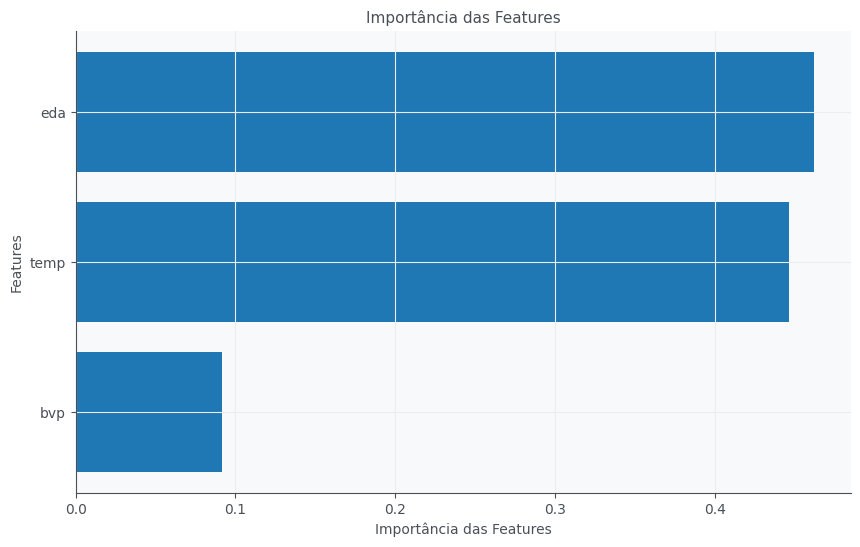

In [10]:
# -- feature importance graph
importances = clf.feature_importances_
feature_names = X_train.columns

# Ordene as importâncias e os nomes das features
sorted_indices = importances.argsort()
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Crie o gráfico de barras das importâncias das features
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
plt.yticks(range(len(sorted_importances)), sorted_feature_names)
plt.xlabel('Importância das Features')
plt.ylabel('Features')
plt.title('Importância das Features')
plt.show()